In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**Image Captioning** là quá trình tạo ra mô tả văn bản cho một hình ảnh. Nó sử dụng cả Xử lý Ngôn ngữ Tự nhiên (NLP) và Thị giác Máy tính (Computer Vision) để tạo ra các chú thích. Nhiệm vụ này nằm ở giao điểm của thị giác máy tính và xử lý ngôn ngữ tự nhiên. Hầu hết các hệ thống chú thích hình ảnh sử dụng khung mã hóa-giải mã, trong đó hình ảnh đầu vào được mã hóa thành một biểu diễn trung gian của thông tin trong hình ảnh, sau đó được giải mã thành một chuỗi văn bản mô tả.

**Mô hình CNNs + RNNs (LSTMs)**

Để thực hiện Image Captioning, nhóm đề xuất hai mô hình học sâu kết hợp thành một cho mục đích huấn luyện. CNNs trích xuất các đặc trưng từ hình ảnh dưới dạng một vector có kích thước nào đó, gọi là vector embeddings. Kích thước của các embeddings này phụ thuộc vào loại mạng được huấn luyện trước được sử dụng để trích xuất đặc trưng. LSTMs được sử dụng cho quá trình tạo văn bản. Các embeddings của hình ảnh được nối với embeddings của từ và được truyền vào LSTM để tạo ra từ tiếp theo.

In [2]:
image_path = '../Images'

In [ ]:
data = pd.read_csv("../captions.txt")
data.head()

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**

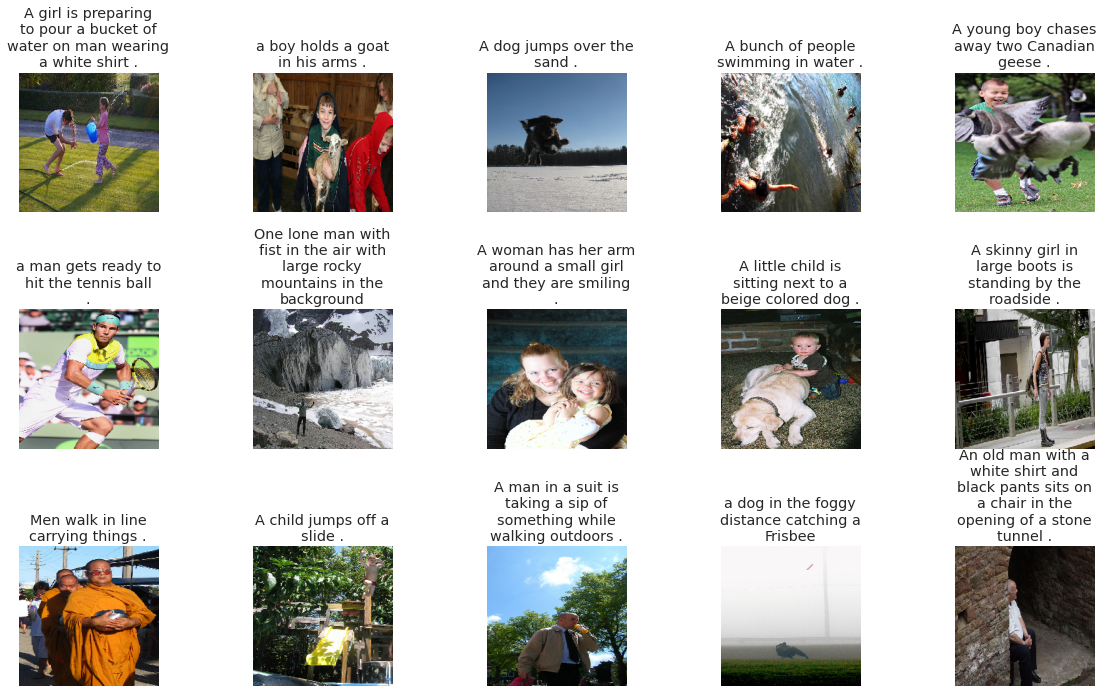

In [ ]:
display_images(data.sample(15))

# **Xử lý dữ liệu**
- Chuyển các câu thành chữ thường
- Loại bỏ các ký tự đặc biệt và số có trong văn bản
- Loại bỏ khoảng trắng thừa
- Loại bỏ các ký tự đơn
- Thêm thẻ bắt đầu và kết thúc vào các câu.


In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## _Mã hóa dữ liệu_
- Các từ trong một câu được tách ra/thành từng từ riêng lẻ và được mã hóa bằng cách biểu diễn one-hot
- Các mã hóa này sau đó được truyền vào lớp embeddings để tạo ra các embeddings của từ

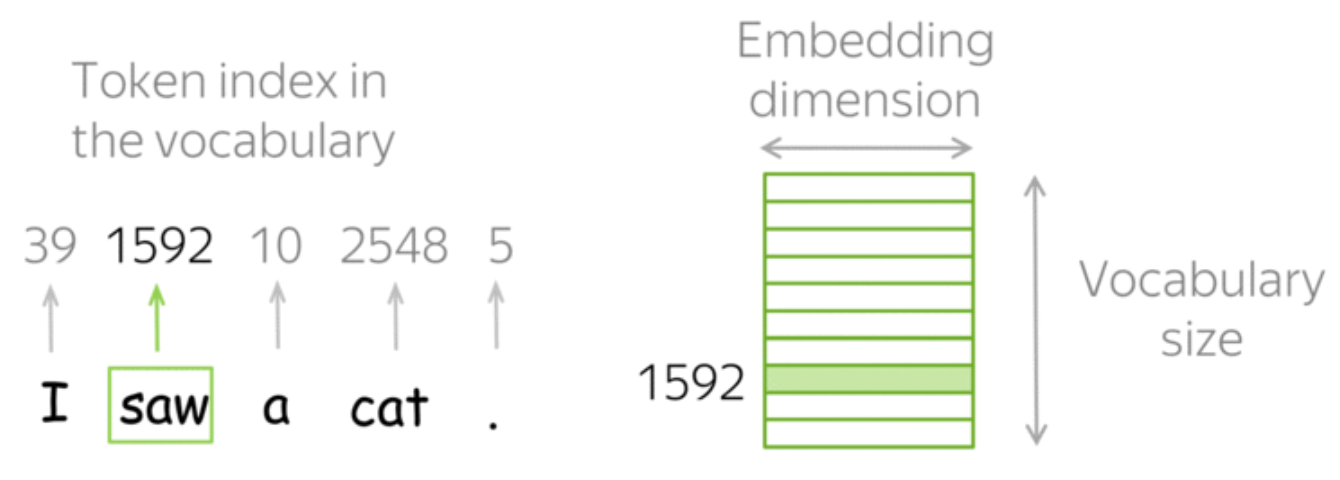

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Trích xuất đặc trưng ảnh**
- DenseNet 201 được dùng để trích xuất ra các vector 1920 chiều biểu diễn đặc trưng cho từng ảnh


<img src="https://imgur.com/wWHWbQt.jpg">

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82534400/82524592 [==============================] - 0s 0us/step


100%|██████████| 8091/8091 [11:42<00:00, 11.52it/s]


# **Data Generation**
- Vì quá trình huấn luyện mô hình là một quá trình sử dụng tài nguyên cao, chúng ta không thể tải toàn bộ dữ liệu vào bộ nhớ chính cùng một lúc, do đó, chúng ta cần tạo dữ liệu theo từng lô với định dạng cần thiết.
- Đầu vào sẽ là các embeddings của hình ảnh và các embeddings của văn bản chú thích tương ứng cho quá trình huấn luyện.
- Các embeddings của văn bản được truyền từng từ một để tạo chú thích trong thời gian suy luận.

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# **Modelling**
- Các biểu diễn embedding của hình ảnh được nối với từ đầu tiên của câu, tức là startseq, và được truyền vào mạng LSTM.
- Mạng LSTM bắt đầu tạo các từ sau mỗi đầu vào, do đó hình thành một câu hoàn chỉnh ở cuối.

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- Một thay đổi nhỏ đã được thực hiện trong kiến trúc mô hình ban đầu để cải thiện hiệu suất. Các embeddings đặc trưng hình ảnh được thêm vào đầu ra của LSTM và sau đó được truyền vào các lớp fully connected.
- Điều này cải thiện nhẹ hiệu suất của mô hình ban đầu được đề xuất vào năm 2014: Show and Tell: A Neural Image Caption Generator (https://arxiv.org/pdf/1411.4555.pdf)

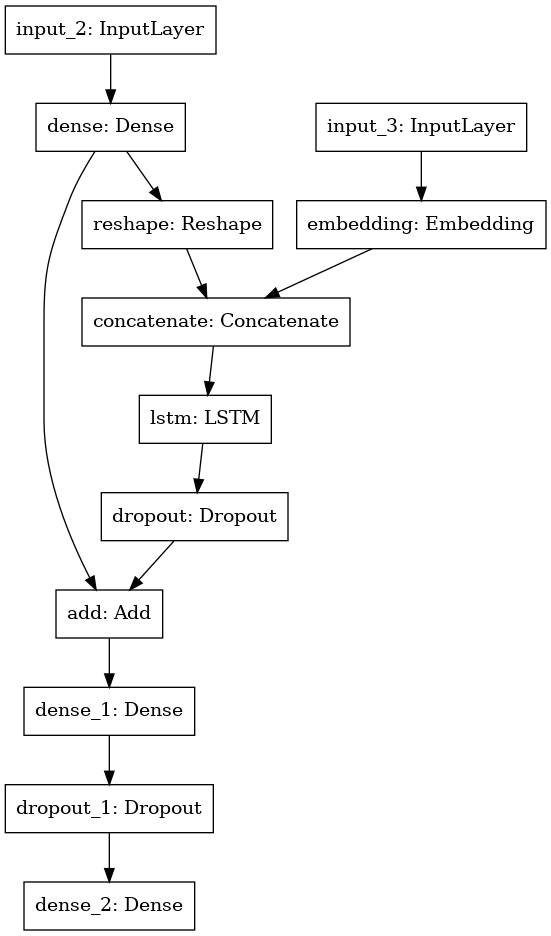

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1920)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          491776      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 256)       0           dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

## **Train Model**


In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - 224s 412ms/step - loss: 5.1442 - val_loss: 4.2569

Epoch 00001: val_loss improved from inf to 4.25690, saving model to model.h5
Epoch 2/50
537/537 [==============================] - 47s 87ms/step - loss: 4.1876 - val_loss: 3.9077

Epoch 00002: val_loss improved from 4.25690 to 3.90766, saving model to model.h5
Epoch 3/50
537/537 [==============================] - 47s 88ms/step - loss: 3.9151 - val_loss: 3.7666

Epoch 00003: val_loss improved from 3.90766 to 3.76663, saving model to model.h5
Epoch 4/50
537/537 [==============================] - 46s 85ms/step - loss: 3.7538 - val_loss: 3.6870

Epoch 00004: val_loss improved from 3.76663 to 3.68698, saving model to model.h5
Epoch 5/50
537/537 [==============================] - 47s 88ms/step - loss: 3.6374 - val_loss: 3.6504

Epoch 00005: val_loss improved from 3.68698 to 3.65041, saving model to model.h5
Epoch 6/50
537/537 [==============================] - 47s 87ms/step - loss: 3.5476

## **Learning Curve**


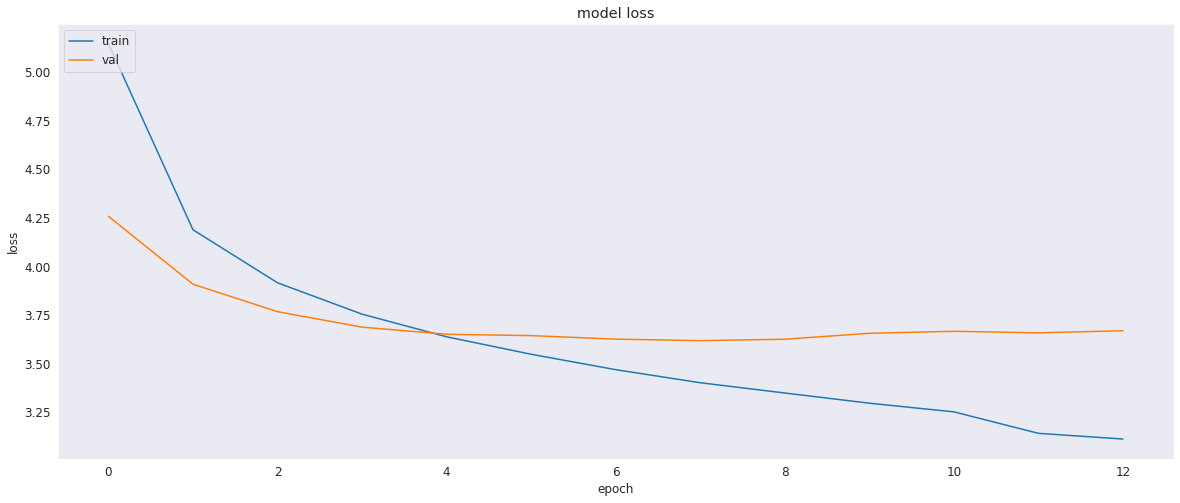

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Functions**

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

## **Lấy random 15 mẫu thử cho Caption Prediction**

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

# **Results**
- Kết quả đạt được từ mô hình khá ấn tượng, song vẫn còn những lỗi sai như: thừa từ, nhận diện sai đối tượng, …


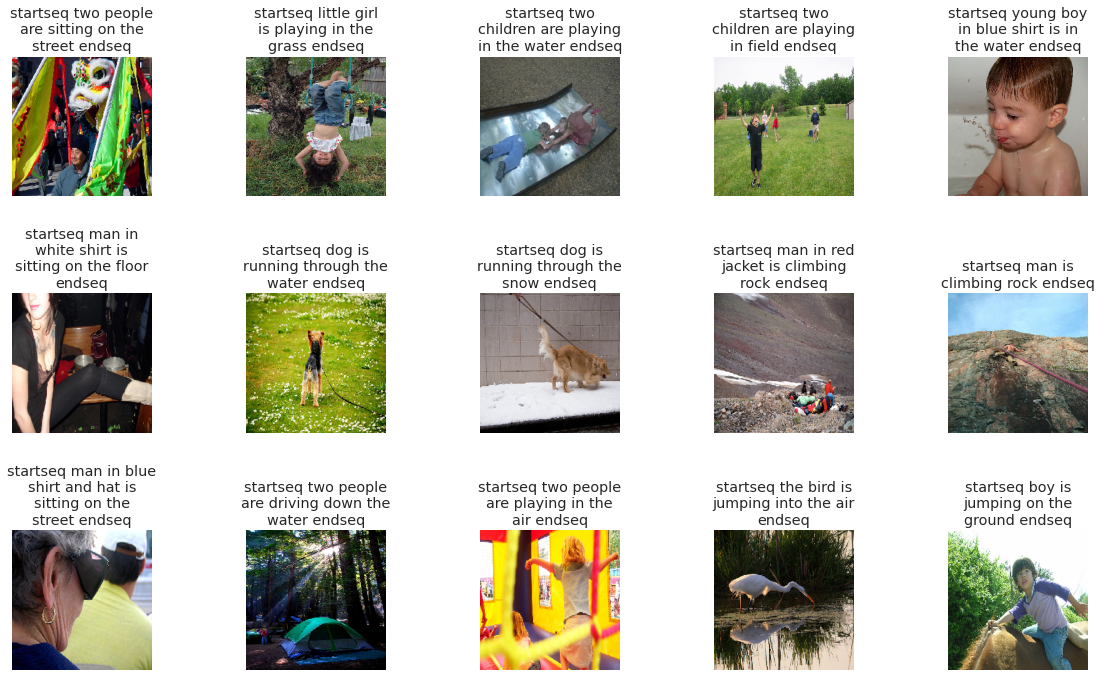

In [ ]:
display_images(samples)

<p style='font-size: 18px'><strong>Kết luận: </strong> 
Trong tương lai chúng em có thể cải thiện hiệu suất của mô hình bằng cách thu thập và huấn luyện trên nhiều dữ liệu hơn, hay sử dụng cơ chế Attention để giúp mô hình có thể tập trung vào các phần quan trọng của hình ảnh khi sinh ra mỗi từ ở Decoder.